### [ 2026-01-23] 과제
- 데이터셋 : NYC Taxi Dataset
-    주제 : 장거리 Trip 분류 => F1

In [130]:
# 컬럼 정리 
# | No | Column Name (English) | 컬럼명 (한글)     

# | 0  | VendorID              | 택시 회사 ID     
# | 1  | tpep_pickup_datetime  | 승차 일시        
# | 2  | tpep_dropoff_datetime | 하차 일시        
# | 3  | passenger_count       | 승객 수        
# | 4  | trip_distance         | 주행 거리        
# | 5  | pickup_longitude      | 승차 위치 경도     
# | 6  | pickup_latitude       | 승차 위치 위도     
# | 7  | RateCodeID            | 요금 코드        
# | 8  | store_and_fwd_flag    | 데이터 저장/전송 여부 
# | 9  | dropoff_longitude     | 하차 위치 경도     
# | 10 | dropoff_latitude      | 하차 위치 위도     
# | 11 | payment_type          | 결제 방식      
# | 12 | fare_amount           | 기본 요금        
# | 13 | extra                 | 추가 요금        
# | 14 | mta_tax               | MTA 세금       
# | 15 | tip_amount            | 팁            
# | 16 | tolls_amount          | 통행료          
# | 17 | improvement_surcharge | 개선 부담금       
# | 18 | total_amount          | 총 요금         

### 필요한 컬럼
- 타겟 : 
    - trip_distance 기준으로 새로 생성 -> long_trip(0: 단거리, 1: 장거리)
- 피쳐 : 
    - passenger_count       | 승객 수  
    - pickup_longitude      | 승차 위치 경도     
    - pickup_latitude       | 승차 위치 위도   
    - dropoff_longitude     | 하차 위치 경도     
    - dropoff_latitude      | 하차 위치 위도  
    - total_amount          | 총 요금

[0] 컴퓨터 성능 확인 <hr>

In [131]:
# ================================================================================
# [1-1] 모듈 로딩
# ================================================================================
import os, sys
sys.path.append(os.path.abspath(".."))

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchinfo import summary
from torch.utils.data import Dataset, DataLoader, Subset
from sklearn.model_selection import train_test_split

import pandas as pd
import numpy as np

import pyarrow
# PyArrow는 Apache Arrow의 Python 버전으로, 대용량 데이터를 매우 빠르게 처리하는 라이브러리

from sklearn.preprocessing import StandardScaler

from Utils import util_func as uf 

In [ ]:
# ================================================================================
# [1-2] 데이터 준비
# ================================================================================
datas = ["./DATA/yellow_tripdata_2015-01.csv",
         "./DATA/yellow_tripdata_2016-01.csv",
         "./DATA/yellow_tripdata_2016-02.csv",
         "./DATA/yellow_tripdata_2016-03.csv"]

# 사용할 컬럼
usecols = ['trip_distance', 
           'passenger_count',
           'pickup_longitude', 'pickup_latitude',
           'dropoff_longitude', 'dropoff_latitude',
           'total_amount'
]

# 데이터 load
dataList = [pd.read_csv(data, engine="pyarrow", usecols=usecols) for data in datas]

# 데이터 concat
dataDF = pd.concat(dataList, ignore_index=True) # 인덱스 새로 부여

# 데이터 sampling
dataDF = dataDF.sample(frac=0.05, random_state=10)  # 데이터의 5%만 사용

In [133]:
# dataDF1 = pd.read_csv("./DATA/yellow_tripdata_2015-01.csv")
# dataDF2 = pd.read_csv("./DATA/yellow_tripdata_2016-01.csv")
# dataDF3 = pd.read_csv("./DATA/yellow_tripdata_2016-02.csv")
# dataDF4 = pd.read_csv("./DATA/yellow_tripdata_2016-03.csv")

# print(f"shape: {dataDF1.shape}")
# print(f"shape: {dataDF2.shape}")
# print(f"shape: {dataDF3.shape}")
# print(f"shape: {dataDF4.shape}")

# # shape: (12748986, 19)
# # shape: (10906858, 19)
# # shape: (11382049, 19)
# # shape: (12210952, 19)

In [134]:
# ================================================================================
# [1-3] 데이터 확인
# ================================================================================
display(dataDF.tail())

print(f"[dataDF] {dataDF.shape}")

,trip_distance,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,total_amount
32948271,2.60,2,-73.986763,40.725643,-73.978065,40.753258,16.55
23309632,2.28,1,-73.981941,40.757702,-73.954842,40.773590,9.30
5732658,1.08,1,-73.991005,40.727848,-73.995522,40.736816,9.20
11346697,0.69,1,-74.004265,40.738102,-73.997910,40.740253,5.80
42202820,12.25,1,-73.873177,40.774158,-73.842773,40.855259,40.84


[dataDF] (2362442, 7)


[2] 데이터 전처리 <hr>

In [135]:
# ================================================================================
# [2-1] 데이터 결측치/중복값 처리
# ================================================================================
print(f"데이터 중복값 : {dataDF.duplicated().sum()}\n")

dataDF = dataDF.drop_duplicates()

print(f"데이터 중복값 : {dataDF.duplicated().sum()}")
print(f"데이터 중복 처리 완료\n")

print(f"데이터 결측치값 : \n{dataDF.isna().sum()}")

데이터 중복값 : 17367

데이터 중복값 : 0
데이터 중복 처리 완료

데이터 결측치값 : 
trip_distance        0
passenger_count      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
total_amount         0
dtype: int64


In [136]:
# ================================================================================
# [2-2] 데이터 이상치값 처리
# ================================================================================
# 승객수가 음수면 이상치라고 판단
# 총금액이 음수거나 200달러 이상이면 이상치라고 판단(약 30만원)
# 위도 경도가 -90° ~ 90°,  -180° ~ 180°이 아니면 이상치라고 판단

for col in dataDF.columns:
    print(f"{col:25s} | 최소: {dataDF[col].min():12.2f} | 최대: {dataDF[col].max():12.2f} | 범위: {dataDF[col].max() - dataDF[col].min():12.2f}")


print(f"\ntotal_amount  99.99% 백분위수: ${dataDF['total_amount'].quantile(0.9999):.2f}")
print(f"\ntrip_distance 99.9997% 백분위수: {dataDF['trip_distance'].quantile(0.999997):.2f}\n")

outlier = dataDF[(dataDF['passenger_count'] < 0) | 
                 (dataDF['dropoff_latitude'] > 90) |             
                 (dataDF['total_amount'] < 0) | (dataDF['total_amount'] > 200) |   
                 (dataDF['trip_distance'] > 1000)] 

dataDF = dataDF[(dataDF['passenger_count'] >= 0) & 
                (dataDF['dropoff_latitude'] <= 90) &            
                (dataDF['total_amount'] >= 0) & (dataDF['total_amount'] <= 200) &  
                (dataDF['trip_distance'] <= 1000)]  

print("이상치 처리 완료\n")

for col in dataDF.columns:
    print(f"{col:25s} | 최소: {dataDF[col].min():12.2f} | 최대: {dataDF[col].max():12.2f} | 범위: {dataDF[col].max() - dataDF[col].min():12.2f}")

trip_distance             | 최소:         0.00 | 최대:   8000010.00 | 범위:   8000010.00
passenger_count           | 최소:         0.00 | 최대:         9.00 | 범위:         9.00
pickup_longitude          | 최소:      -121.93 | 최대:         0.00 | 범위:       121.93
pickup_latitude           | 최소:         0.00 | 최대:        45.18 | 범위:        45.18
dropoff_longitude         | 최소:      -121.93 | 최대:         0.00 | 범위:       121.93
dropoff_latitude          | 최소:         0.00 | 최대:       459.53 | 범위:       459.53
total_amount              | 최소:      -376.30 | 최대:      8008.80 | 범위:      8385.10

total_amount  99.99% 백분위수: $210.90

trip_distance 99.9997% 백분위수: 812.37

이상치 처리 완료

trip_distance             | 최소:         0.00 | 최대:       818.60 | 범위:       818.60
passenger_count           | 최소:         0.00 | 최대:         9.00 | 범위:         9.00
pickup_longitude          | 최소:      -121.93 | 최대:         0.00 | 범위:       121.93
pickup_latitude           | 최소:         0.00 | 최대:        45.18 | 범위:        45.18
dr

In [137]:
# ================================================================================
# [2-3] 데이터 스케일링 : 피쳐의 범위가 극단적으로 다름
# ================================================================================
# passenger_count      : 승객수는 카테고리가 아니라 연속형 수치 피처 -> 스케일링 해야 함, 다른 피쳐들과 값차이 큼
# pickup_longitude     : 범위 121.93
# pickup_latitude      : 범위 45.18 
# dropoff_longitude    : 범위 121.93 
# dropoff_latitude     : 범위 50.77
# total_amount         : 범위 200.00 
# ================================================================================
scaler = StandardScaler()
dataDF[dataDF.columns[1:-1]] = scaler.fit_transform(dataDF[dataDF.columns[1:-1]].values)

In [138]:
# ================================================================================
# [2-4] 데이터 타겟 직접 추가
# ================================================================================
print(f"[dataDF] {dataDF.shape}")

# trip_distance 기준 상위 10%를 장거리 운전으로 취급
threshold = dataDF["trip_distance"].quantile(0.9) # 상위 10% 시작점 저장

dataDF.loc[:,"is_long_trip"] = (dataDF["trip_distance"] >= threshold ).astype(int)

display(dataDF.tail())

print(dataDF["is_long_trip"].value_counts())

[dataDF] (2343979, 7)


,trip_distance,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,total_amount,is_long_trip
32948271,2.60,0.248564,-0.097197,0.088804,-0.091410,0.091183,16.55,0
23309632,2.28,-0.505810,-0.096507,0.097126,-0.087924,0.096723,9.30,0
5732658,1.08,-0.505810,-0.097803,0.089376,-0.094031,0.086703,9.20,0
11346697,0.69,-0.505810,-0.099699,0.092038,-0.094389,0.087640,5.80,0
42202820,12.25,-0.505810,-0.080953,0.101398,-0.071102,0.118977,40.84,1


is_long_trip
0    2107611
1     236368
Name: count, dtype: int64


In [139]:
dataDF[dataDF.columns[1:]]

,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,total_amount,is_long_trip
14289219,-0.505810,-0.100151,0.093290,-0.091697,0.091110,15.95,0
2044873,-0.505810,-0.095066,0.096383,-0.091764,0.094179,12.30,0
24199753,3.266058,-0.095331,0.097862,-0.089406,0.096472,7.56,0
6620774,-0.505810,-0.097622,0.091103,-0.080987,0.070763,25.30,1
19026332,-0.505810,-0.095367,0.097009,-0.088500,0.097920,11.16,0
...,...,...,...,...,...,...,...
32948271,0.248564,-0.097197,0.088804,-0.091410,0.091183,16.55,0
23309632,-0.505810,-0.096507,0.097126,-0.087924,0.096723,9.30,0
5732658,-0.505810,-0.097803,0.089376,-0.094031,0.086703,9.20,0
11346697,-0.505810,-0.099699,0.092038,-0.094389,0.087640,5.80,0


[3] 커스텀 데이터셋 생성

In [140]:
# ================================================================================
# [3-1] 커스텀 데이터셋 클래스 정의
# ================================================================================
# 클래스이름 : TaxiDataset
# 부모클래스 : Dataset
# 오버라이딩 : __init__()
#            __len__()
#            __getitem__()
# ================================================================================
class TaxiDataset(Dataset):
    def __init__(self, dataDF):
        super().__init__()

        # 피쳐
        self.x = dataDF[dataDF.columns[1:-1]].values
        # 타겟
        self.y = dataDF[dataDF.columns[-1]].values

    def __len__(self):
        return self.x.shape[0]
    
    def __getitem__(self, index):
        xTS = torch.tensor(self.x[index], dtype=torch.float32)
        yTS = torch.tensor(self.y[index], dtype=torch.float32)

        return xTS, yTS

In [141]:
# ================================================================================
# [3-2] 커스텀 데이터셋 인스턴스 생성 및 사용
# ================================================================================
allDS = TaxiDataset(dataDF)

print(f"allDS : {len(allDS)}")

allDS : 2343979


In [142]:
# ================================================================================
# [3-3] 학습용/검증용/테스트용 데이터셋 분리
# ================================================================================
# 타겟 리스트
targetList = allDS.y

# 전체 인덱스 리스트
dataIndexList = list(range(len(allDS)))

# 테스트용 데이터셋 분리
x_tempIdx, x_test_Idx, y_temp, y_test = train_test_split(
    dataIndexList,
    targetList,
    stratify=targetList,
    test_size=0.1,
    random_state=10
)  

# 학습용/검증용 데이터셋 분리
x_train_idx, x_valid_idx, y_train, y_valid = train_test_split(
    x_tempIdx,
    y_temp,
    stratify=y_temp,
    test_size=0.2,
    random_state=10
)

In [143]:
# ================================================================================
# [3-4] 학습용/검증용/테스트용 데이터셋 생성
# ================================================================================
trainDS = Subset(allDS, x_train_idx)
validDS = Subset(allDS, x_valid_idx)
testDS = Subset(allDS, x_test_Idx)

print(f"allDS : {len(allDS)}, trainDS : {len(trainDS)}, validDS : {len(validDS)}, testDS : {len(testDS)}")

allDS : 2343979, trainDS : 1687664, validDS : 421917, testDS : 234398


[4] 모델 클래스 설계 <hr>

In [144]:
# ================================================================================
# [4-1] 커스텀 모델 클래스 정의
# ================================================================================
#              입력            출력             AF
# 입력층          6              6              -        
# 은닉층1         6             128            ReLU
# 은닉층2        128             64            ReLU
# 은닉층3         64             16            ReLU
# 출력층          16              1             -    BCEWithLogitsLoss() -> Sigmoid 내장   
# ================================================================================
class taxiModel(nn.Module):

    def __init__(self, in_, out_, hd1, hd2, hd3):
        
        super().__init__()
        self.hd1_layer = nn.Linear(in_, hd1)
        self.hd2_layer = nn.Linear(hd1, hd2)
        self.hd3_layer = nn.Linear(hd2, hd3)
        self.out_layer = nn.Linear(hd3, out_)

    def forward(self, data):

        # 입력층  -> 은닉층1
        out = F.relu(self.hd1_layer(data))

        # 은닉층1 -> 은닉층2
        out = F.relu(self.hd2_layer(out))
    
        # 은닉층2 -> 은닉층3
        out = F.relu(self.hd3_layer(out)) 

        # 은닉층3 -> 출력층
        out = self.out_layer(out)

        return out.squeeze(-1)

[5] 학습 준비 <hr>

In [145]:
# ================================================================================
# [5-1] 학습 관련 설정
# ================================================================================
EPOCHS = 20
BATCH_SIZE = 4096           
LR = 0.01
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

print(f"사용 장치 : {DEVICE}")

# ================================================================================
# [5-2] 학습 관련 인스턴스 생성
# ================================================================================
model = taxiModel(6, 1, 128, 64, 16).to(DEVICE)

# 손실함수 BCEWithLogitsLoss() : 이진분류용 
lossFN = nn.BCEWithLogitsLoss()  # sigmoid 내장

optimizer = optim.Adam(model.parameters(), lr=LR)

trainDL = DataLoader(trainDS, batch_size=BATCH_SIZE,shuffle=True,)
validDL = DataLoader(validDS, batch_size=BATCH_SIZE)
testDL = DataLoader(testDS, batch_size=BATCH_SIZE)

사용 장치 : cuda


[6] 학습 진행 <HR>

In [147]:
# ================================================================================
# [6-1] 학습 진행
# ================================================================================
HISTORY = {
    "train_loss": [], 
    "train_acc": [], 
    "train_f1": [],     
    "val_loss": [], 
    "val_acc": [],
    "val_f1": []         
}

best_valid_f1 = 0  # 최고 F1 점수 

for epoch in range(EPOCHS):

    # 1에포크 학습
    train_loss, train_acc, train_f1 = uf.train_one_epoch(
        model, 
        trainDL, 
        lossFN, 
        optimizer, 
        DEVICE)
    
    # 1에포크 학습 후 업데이트 W, b 검사
    val_loss, val_acc, val_f1 = uf.evaluate(
        model, 
        validDL, 
        lossFN, 
        DEVICE)
    
    # 학습과 검증 결과 저장 
    HISTORY['train_loss'].append(train_loss)
    HISTORY['train_acc'].append(train_acc)
    HISTORY['train_f1'].append(train_f1)
    HISTORY['val_loss'].append(val_loss)
    HISTORY['val_acc'].append(val_acc)
    HISTORY['val_f1'].append(val_f1)

    # 진행 상황 출력
    print(f"Epoch [{epoch+1:2d}/{EPOCHS}] "
          f"[LOSS] train:valid={train_loss:.5f}:{val_loss:.5f} "
          f"[ACC] train:valid={train_acc:.4f}:{val_acc:.4f} "
          f"[F1] train:valid={train_f1:.4f}:{val_f1:.4f}",
          flush=True)
    
    #  F1 최고 성능일 때 모델 저장
    if val_f1 > best_valid_f1:
        best_valid_f1 = val_f1
        torch.save(model.state_dict(), f'./model/model-{val_f1:.2f}.pth')
        print(f"모델 저장 (Epoch {epoch+1}, F1: {val_f1:.4f})")
    else:
        print()

print(f"\n최고 성능 모델 저장 완료 (F1: {best_valid_f1:.4f})")

Epoch [ 1/20] [LOSS] train:valid=0.09280:0.05849 [ACC] train:valid=0.9704:0.9757 [F1] train:valid=0.8413:0.8727
모델 저장 (Epoch 1, F1: 0.8727)
Epoch [ 2/20] [LOSS] train:valid=0.05897:0.09782 [ACC] train:valid=0.9754:0.9660 [F1] train:valid=0.8718:0.8506

Epoch [ 3/20] [LOSS] train:valid=0.05929:0.05778 [ACC] train:valid=0.9753:0.9748 [F1] train:valid=0.8717:0.8666

Epoch [ 4/20] [LOSS] train:valid=0.05836:0.07321 [ACC] train:valid=0.9756:0.9752 [F1] train:valid=0.8731:0.8803
모델 저장 (Epoch 4, F1: 0.8803)
Epoch [ 5/20] [LOSS] train:valid=0.05820:0.05918 [ACC] train:valid=0.9756:0.9744 [F1] train:valid=0.8733:0.8627

Epoch [ 6/20] [LOSS] train:valid=0.05775:0.08209 [ACC] train:valid=0.9758:0.9657 [F1] train:valid=0.8740:0.8020

Epoch [ 7/20] [LOSS] train:valid=0.05783:0.06010 [ACC] train:valid=0.9758:0.9752 [F1] train:valid=0.8738:0.8705

Epoch [ 8/20] [LOSS] train:valid=0.05739:0.05872 [ACC] train:valid=0.9760:0.9772 [F1] train:valid=0.8749:0.8857
모델 저장 (Epoch 8, F1: 0.8857)
Epoch [ 9/20] [

[6] 시각화 <hr>

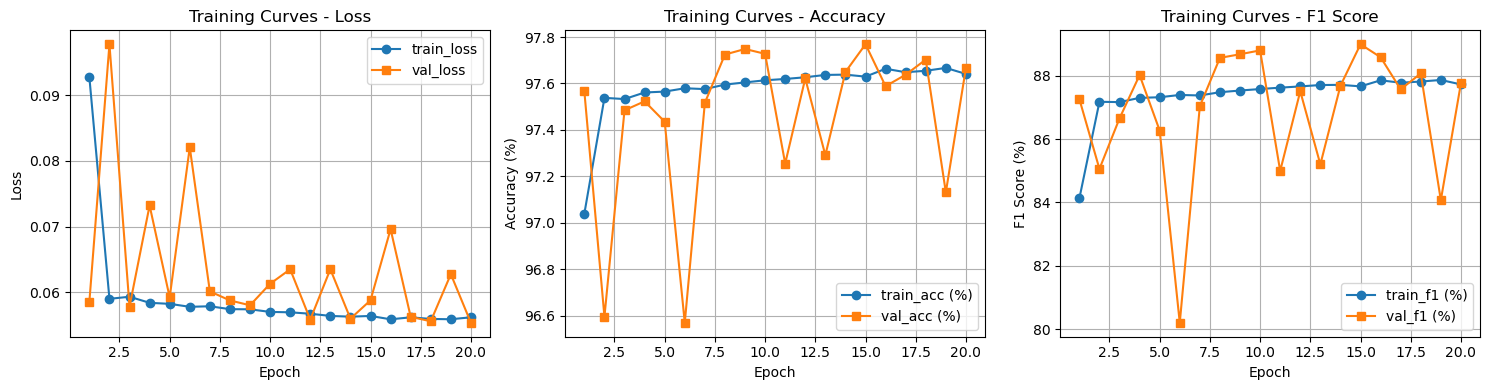

In [148]:
uf.plot_history(HISTORY)

[7] 모델 로드 및 예측 <HR>

In [149]:
# ================================================================================
# [7-1] 모델 불러오기
# ================================================================================
model = taxiModel(6, 1, 128, 64, 16).to(DEVICE)
model.load_state_dict(torch.load('./model/model-0.89.pth', map_location=DEVICE, weights_only=True))
model.eval()
print("모델 로드 완료")

모델 로드 완료


In [ ]:
# ================================================================================
# [7-2] 예측 함수
# ================================================================================
def predict(x_data):
    """
    x_data: numpy 배열 또는 리스트
    예: [-0.505810, -0.080953, 0.101398, -0.071102, 0.118977, 40.84]s
    """
    x_tensor = torch.FloatTensor(x_data).unsqueeze(0).to(DEVICE)
    
    with torch.no_grad():
        output = model(x_tensor)
        prob = torch.sigmoid(output).item()
        pred = 1 if prob >= 0.5 else 0
    
    return pred, prob


# ================================================================================
# [7-3] 예측 실행
# ================================================================================
test_data = [-0.505810, -0.080953, 0.101398, -0.071102, 0.118977, 40.84]

pred, prob = predict(test_data)

print(f"\n예측 결과:")
print(f"라벨: {pred} ({'Long Trip' if pred == 1 else 'Short Trip'})")
print(f"확률: {prob:.4f}")


예측 결과:
라벨: 1 (Long Trip)
확률: 0.9788
